In [1]:
from pathlib import Path
from typing import List, Tuple

import IPython.display as ipd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm

from speaker_recognition import Conformer, ModelParams, SpeakerDataset

plt.style.use("ggplot")
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.spines.bottom"] = False

/opt/homebrew/Caskroom/miniforge/base/envs/voice_course3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### [VoxTube](https://github.com/IDRnD/VoxTube) Russian Subset

In [2]:
conf = ModelParams()

model = Conformer(conf)

ckpt = torch.load("./data/epoch_100.ckpt", map_location="cpu")

model.load_state_dict(ckpt["model_state_dict"])
model.eval();

/var/folders/1w/55f2466j79335k2064k2wj480000gn/T/ipykernel_48249/3836028661.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./data/epoch_100.ckpt", ma

In [3]:
sum(torch.numel(p) for p in model.parameters())

58137

In [4]:
dataset = SpeakerDataset(dataset_dir=Path("./data/dev"))

In [5]:
next(iter(dataset))

(0, tensor([ 0.0387,  0.0407,  0.0405,  ...,  0.0280, -0.0015, -0.0252]), 0)

In [6]:
embs = []
labels = []

with torch.no_grad():
    for idx, wav, label in tqdm(dataset):
        emb, _ = model(wav.unsqueeze(0))
        embs.append(emb)
        labels.append(label)

np_labels = np.array(labels)

embs_matrix = torch.cat(embs)
embs_matrix = embs_matrix / (embs_matrix**2).sum(1, keepdim=True) ** 0.5

100%|██████████| 2060/2060 [00:06<00:00, 333.69it/s]


In [7]:
scores = (embs_matrix @ embs_matrix.T).numpy()

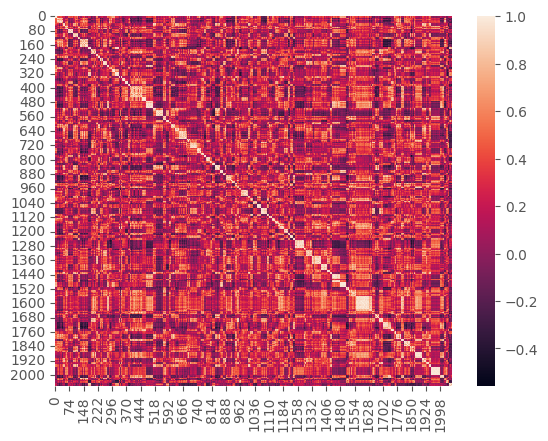

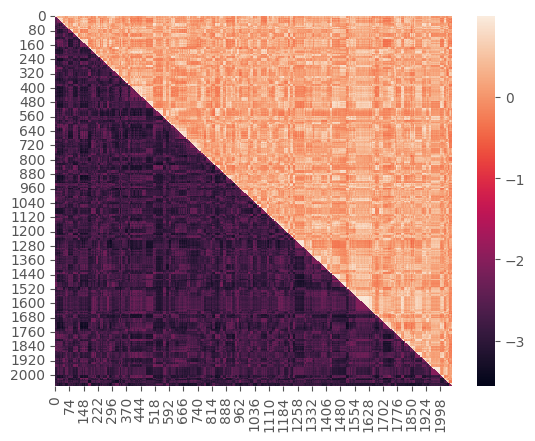

In [8]:
sns.heatmap(scores)
plt.show()

mask = np.tril(np.ones_like(scores)) * (-3)
masked_scores = scores + mask

sns.heatmap(masked_scores)
plt.show()

In [9]:
pos_total = []
neg_total = []

for voiceid in np.unique(np_labels):
    (idx,) = (np_labels == voiceid).nonzero()

    pos_scores = masked_scores[idx, :][:, idx]
    pos_scores = pos_scores[pos_scores > -1]

    other_idx_mask = ~np.isin(np.arange(masked_scores.shape[1]), idx)
    neg_scores = masked_scores[idx, :][:, other_idx_mask]
    neg_scores = neg_scores[neg_scores > -1]

    pos_total.extend(pos_scores)
    neg_total.extend(neg_scores)

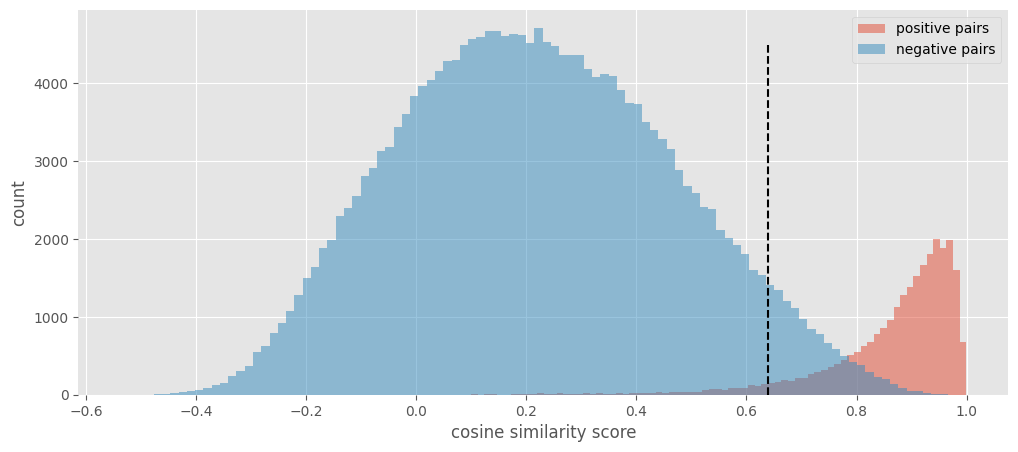

In [10]:
neg_sampled = np.random.choice(neg_total, size=int(len(neg_total) * 0.1), replace=False)


plt.figure(figsize=(12, 5), edgecolor="g")
plt.hist(pos_total, bins=100, alpha=0.5, color="#E24A33", label="positive pairs")
plt.hist(neg_sampled, bins=100, alpha=0.5, color="#348ABD", label="negative pairs")
plt.plot([0.64, 0.64], [0, 4500], "k--")
plt.xlabel("cosine similarity score")
plt.ylabel("count")
plt.legend()
plt.savefig("cosine distribution.png", dpi=300)
plt.show()

In [11]:
bin_labels = np.concatenate((np.zeros_like(neg_total), np.ones_like(pos_total))).astype(
    "int"
)
bin_scores = np.concatenate((neg_total, pos_total))

order = bin_scores.argsort()

sort_bin_labels = bin_labels[order]
sort_bin_scores = bin_scores[order]

neg_count = np.zeros_like(sort_bin_labels)
pos_count = np.zeros_like(sort_bin_labels)

for i, label in enumerate(sort_bin_labels):
    neg_count[i] = (label == 0) + (neg_count[i - 1] if i > 0 else 0)
    pos_count[i] = (label == 1) + (pos_count[i - 1] if i > 0 else 0)

neg_cnt_total = neg_count[-1]
pos_cnt_total = pos_count[-1]

borders = (sort_bin_scores[1:] + sort_bin_scores[:-1]) / 2

frr = []
far = []

for n, p in zip(neg_count, pos_count):
    tn = n
    fp = neg_cnt_total - tn
    fn = p
    tp = pos_cnt_total - p

    frr.append(fn / (fn + tp))
    far.append(fp / (fp + tn))

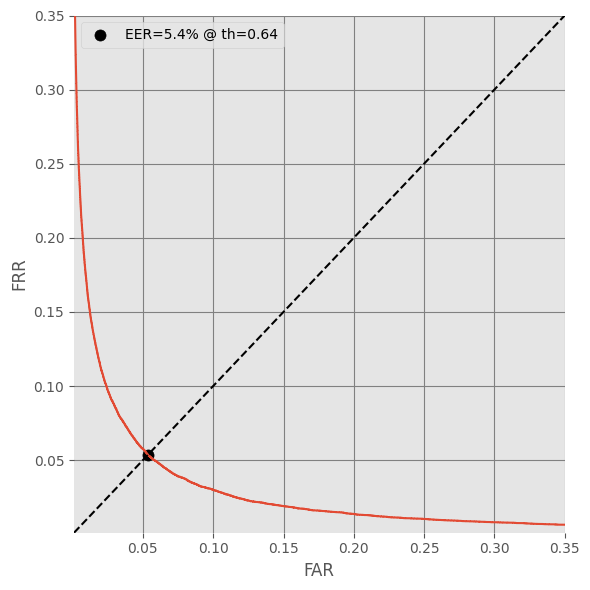

In [12]:
eer_idx = np.abs(np.array(frr) - np.array(far)).argmin()

EER = (frr[eer_idx] + far[eer_idx]) / 2

plt.figure(figsize=(6, 6))
plt.plot(far, frr)
plt.plot([1e-3, 1], [1e-3, 1], "k--")
plt.scatter(
    EER, EER, s=64, c="k", label=f"EER={EER * 100:.1f}% @ th={borders[eer_idx]:.2f}"
)
plt.xlim([1e-3, 0.35])
plt.ylim([1e-3, 0.35])
plt.legend(labelcolor="k")
plt.xlabel("FAR")
plt.ylabel("FRR")
plt.tight_layout()
plt.grid(c="gray")
plt.savefig("DET_curve.png", dpi=300, transparent=True);

In [13]:
large_scores = np.triu(scores * (scores > 0.9), k=1)

low_scores = np.triu(scores * (scores < 0.2), k=1)

fp_errors = []
fn_errors = []

for i, voiceid in enumerate(np.unique(np_labels)):

    (idx,) = (np_labels == voiceid).nonzero()

    x_id_fp, y_id_fp = large_scores[idx, :].nonzero()
    x_id_fn, y_id_fn = low_scores[idx, :].nonzero()

    x_id_fp += min(idx)
    x_id_fn += min(idx)

    fp_err_ids = np.isin(y_id_fp, (np_labels != voiceid).nonzero())
    fn_err_ids = np.isin(y_id_fn, idx)

    for query, result in zip(x_id_fp[fp_err_ids], y_id_fp[fp_err_ids]):
        fp_errors.append((query, result, scores[query, result]))

    for query, result in zip(x_id_fn[fn_err_ids], y_id_fn[fn_err_ids]):
        fn_errors.append((query, result, scores[query, result]))

In [14]:
wavs = [wav for _, wav, _ in dataset]

In [15]:
TOP_K = 3
SR = 16_000

sorted_fp_errors = sorted(fp_errors, key=lambda x: -x[2])

sorted_fn_errors = sorted(fn_errors, key=lambda x: x[2])


def display_pairs(pairs_with_score: List[Tuple[int, int, float]]) -> None:
    for q_id, r_id, score in pairs_with_score:
        print(f"score: {score:.2f}")
        # ipd.display(ipd.YouTubeVideo(dataset.wav_files[q_id].parent.stem))
        # ipd.display(ipd.YouTubeVideo(dataset.wav_files[r_id].parent.stem))
        ipd.display(ipd.Audio(wavs[q_id], rate=SR))
        ipd.display(ipd.Audio(wavs[r_id], rate=SR))

### False Positive

In [16]:
display_pairs(sorted_fp_errors[:TOP_K])

score: 0.98


score: 0.97


score: 0.97


### False Negative

In [17]:
display_pairs(sorted_fn_errors[:TOP_K])

score: -0.20


score: -0.19


score: -0.16
